In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import xgboost as xgb
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

# **Load and Prepare Data**

In [ ]:
# Load the feature-engineered hourly dataset
file_name = 'banff_parking_engineered_HOURLY.csv'

try:
    df = pd.read_csv(file_name)
    print(f"--- File '{file_name}' loaded successfully --- (shape: {df.shape})")

    # Convert Timestamp to datetime and set as index
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.set_index('Timestamp').sort_index()

    print("--- Data Types ---")
    print(df.info())
    print("\n--- Sample Data ---")
    print(df.head())

except FileNotFoundError:
    print(f"ERROR: The file '{file_name}' was not found.")
    print("Please ensure the file is uploaded to your Colab environment.")
except Exception as e:
    print(f"An error occurred: {e}")

--- File 'banff_parking_engineered_HOURLY.csv' loaded successfully --- (shape: (82434, 17))
--- Data Types ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82434 entries, 2025-05-01 01:00:39 to 2025-09-01 08:00:39
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unit                    82434 non-null  object 
 1   Occupancy               82434 non-null  int64  
 2   Max Temp (°C)           82434 non-null  float64
 3   Min Temp (°C)           82434 non-null  float64
 4   Total Precip (mm)       82434 non-null  float64
 5   Spd of Max Gust (km/h)  82434 non-null  float64
 6   Hour                    82434 non-null  int64  
 7   DayOfWeek               82434 non-null  int64  
 8   Month                   82434 non-null  int64  
 9   IsWeekend               82434 non-null  int64  
 10  Occupancy_1hr_Ago       82434 non-null  float64
 11  Occupancy_24hr_Ago      82434 non-null  float64
 12

# **Preprocessing for Modeling**

In [ ]:
if 'df' in locals():
    # --- 1. One-Hot Encode Categorical Features ---
    # 'Unit' is the only categorical feature that needs encoding
    df_processed = pd.get_dummies(df, columns=['Unit'], drop_first=True)
    print(f"Shape after one-hot encoding: {df_processed.shape}")

    # --- 2. Define Features (X) and Targets (y) ---

    # Define the two target variables
    TARGET_REG = 'Occupancy'
    TARGET_CLS = 'Is_Full'

    # Features are all columns EXCEPT the two targets and Percent_Occupancy (which is a data leak for Is_Full)
    excluded_cols = [TARGET_REG, TARGET_CLS, 'Percent_Occupancy']
    FEATURES = [col for col in df_processed.columns if col not in excluded_cols]

    X = df_processed[FEATURES]
    y_reg = df_processed[TARGET_REG]
    y_cls = df_processed[TARGET_CLS]

    # --- Handle Class Imbalance (for Classification Task) ---
    # 'Is_Full' is likely imbalanced (few '1's, many '0's)
    # We can use 'scale_pos_weight' to handle this.
    # Calculate this before splitting to ensure it's based on the full dataset class distribution
    class_counts = y_cls.value_counts()
    scale_pos_weight = class_counts[0] / class_counts[1]
    print(f"\nClass balance check: 'Is_Full' = 1 occurs {class_counts[1] / class_counts.sum() * 100:.2f}% of the time.")
    print(f"Calculated 'scale_pos_weight': {scale_pos_weight:.2f}")


    # --- 3. Handle NaNs ---
    # Lag/rolling features create NaNs at the start. We must drop them.
    initial_rows = X.shape[0]
    X = X.dropna()
    y_reg = y_reg.loc[X.index]
    y_cls = y_cls.loc[X.index]
    final_rows = X.shape[0]
    print(f"{initial_rows - final_rows} rows with NaNs (from lags/rolling features) were dropped.")

    # --- 4. Time-Series Split ---
    # Use TimeSeriesSplit for time-series data to prevent future data from leaking into the training set.
    tscv = TimeSeriesSplit(n_splits=5)

    # We'll use the last split for our final train/test validation
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_reg_train, y_reg_test = y_reg.iloc[train_index], y_reg.iloc[test_index]
        y_cls_train, y_cls_test = y_cls.iloc[train_index], y_cls.iloc[test_index]

    print(f"\n--- Data Split (using TimeSeriesSplit) ---")
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape:     {X_test.shape}")

    # --- 5. Feature Scaling ---
    # Scale features after splitting to prevent data leakage from the test set
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert back to DataFrame for easier handling (e.g., with feature names)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=FEATURES, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=FEATURES, index=X_test.index)

    print("\n--- Features scaled successfully --- ")
else:
    print("DataFrame 'df' not found. Please load the data in the previous cell.")

Shape after one-hot encoding: (82434, 32)

Class balance check: 'Is_Full' = 1 occurs 1.03% of the time.
Calculated 'scale_pos_weight': 95.87
0 rows with NaNs (from lags/rolling features) were dropped.

--- Data Split (using TimeSeriesSplit) ---
Training set shape: (68695, 29)
Test set shape:     (13739, 29)

--- Features scaled successfully --- 


# **Task 1: Regression - Predicting Hourly Occupancy**

In [ ]:
if 'X_train_scaled' in locals():
    print("--- Task 1: REGRESSION Model Training (XGBoost) ---")

    # 1. Initialize the XGBoost Regressor
    # We use 'reg:squarederror' for regression.
    model_xgb_reg = xgb.XGBRegressor(objective='reg:squarederror',
                                     n_estimators=100,
                                     random_state=42,
                                     n_jobs=-1)

    # 2. Train the model
    model_xgb_reg.fit(X_train_scaled, y_reg_train)
    print("Base XGBoost Regressor model trained.")

    # 3. Evaluate the base model on the test set
    print("\n--- Evaluating Base XGBoost Regressor on Test Set ---")
    y_pred_reg = model_xgb_reg.predict(X_test_scaled)

    mae = mean_absolute_error(y_reg_test, y_pred_reg)
    rmse = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg))
    r2 = r2_score(y_reg_test, y_pred_reg)

    print(f"Base Model Test Set Metrics:")
    print(f"  R-squared (R2): {r2:.3f}")
    print(f"  Mean Absolute Error (MAE): {mae:.3f} vehicles")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.3f} vehicles")


else:
    print("Training data not found. Please run the preprocessing cell.")

--- Task 1: REGRESSION Model Training (XGBoost) ---
Base XGBoost Regressor model trained.

--- Evaluating Base XGBoost Regressor on Test Set ---
Base Model Test Set Metrics:
  R-squared (R2): -0.674
  Mean Absolute Error (MAE): 4.533 vehicles
  Root Mean Squared Error (RMSE): 5.175 vehicles


--- Task 1: REGRESSION Model Training (XGBoost) ---
Base XGBoost Regressor model trained.

--- Evaluating Base XGBoost Regressor on Test Set ---
Base Model Test Set Metrics:
  R-squared (R2): -0.674
  Mean Absolute Error (MAE): 4.533 vehicles
  Root Mean Squared Error (RMSE): 5.175 vehicles


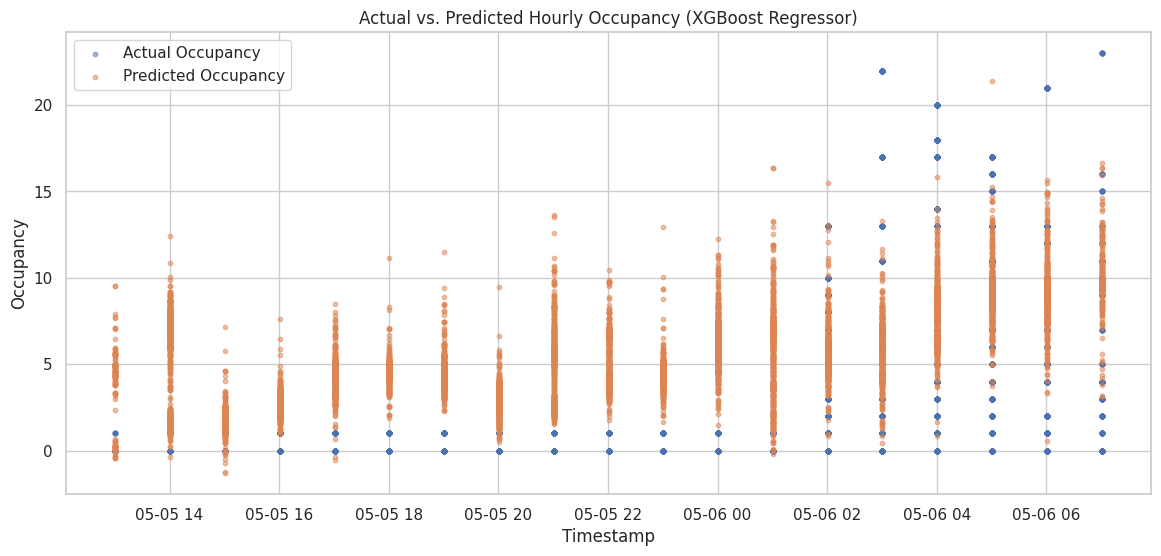

In [ ]:
if 'X_train_scaled' in locals():
    print("--- Task 1: REGRESSION Model Training (XGBoost) ---")

    # 1. Initialize the XGBoost Regressor
    # We use 'reg:squarederror' for regression.
    model_xgb_reg = xgb.XGBRegressor(objective='reg:squarederror',
                                     n_estimators=100,
                                     random_state=42,
                                     n_jobs=-1)

    # 2. Train the model
    model_xgb_reg.fit(X_train_scaled, y_reg_train)
    print("Base XGBoost Regressor model trained.")

    # 3. Evaluate the base model on the test set
    print("\n--- Evaluating Base XGBoost Regressor on Test Set ---")
    y_pred_reg = model_xgb_reg.predict(X_test_scaled)

    mae = mean_absolute_error(y_reg_test, y_pred_reg)
    rmse = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg))
    r2 = r2_score(y_reg_test, y_pred_reg)

    print(f"Base Model Test Set Metrics:")
    print(f"  R-squared (R2): {r2:.3f}")
    print(f"  Mean Absolute Error (MAE): {mae:.3f} vehicles")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.3f} vehicles")

    # 4. Visualize Predicted vs Actual Values (Regression)
    plt.figure(figsize=(14, 6))
    plt.scatter(y_reg_test.index, y_reg_test.values, alpha=0.5, label='Actual Occupancy', s=10)
    plt.scatter(y_reg_test.index, y_pred_reg, alpha=0.5, label='Predicted Occupancy', s=10)
    plt.title('Actual vs. Predicted Hourly Occupancy (XGBoost Regressor)')
    plt.xlabel('Timestamp')
    plt.ylabel('Occupancy')
    plt.legend()
    plt.show()

else:
    print("Training data not found. Please run the preprocessing cell.")


--- Hyperparameter Tuning for XGBoost Regressor ---
(This may take a few minutes)...

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Best cross-validation (negative) MAE: -4.575

--- Evaluating Tuned XGBoost Regressor on Test Set ---
Tuned Model Test Set Metrics:
  R-squared (R2): -0.229
  Mean Absolute Error (MAE): 3.961 vehicles
  Root Mean Squared Error (RMSE): 4.435 vehicles


<Figure size 1500x700 with 0 Axes>

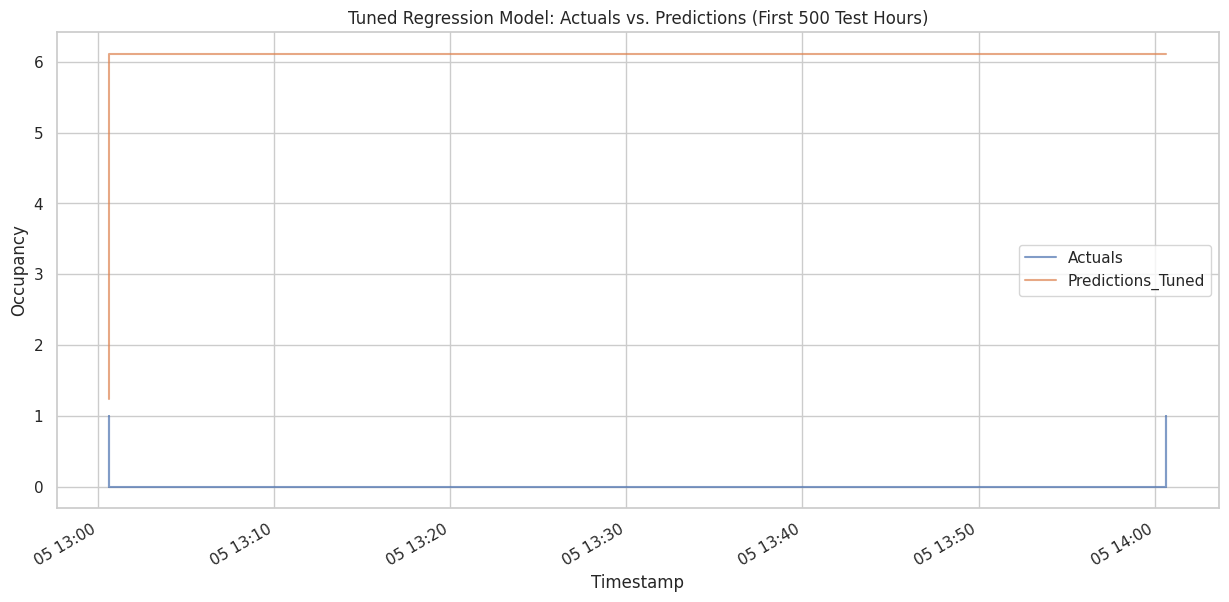

In [ ]:
if 'X_train_scaled' in locals():
    # --- 4. Hyperparameter Tuning (GridSearchCV) ---
    print("\n--- Hyperparameter Tuning for XGBoost Regressor ---")
    print("(This may take a few minutes)...\n")

    # Reduced grid for faster optimization. Expand this for a more thorough search.
    param_grid_xgb_reg = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1],
        'colsample_bytree': [0.7, 1.0]
    }

    # Use the same TimeSeriesSplit for cross-validation within the grid search
    tscv_grid = TimeSeriesSplit(n_splits=5)

    grid_search_reg = GridSearchCV(estimator=model_xgb_reg,
                                 param_grid=param_grid_xgb_reg,
                                 cv=tscv_grid,
                                 scoring='neg_mean_absolute_error', # Optimize for MAE
                                 n_jobs=-1,
                                 verbose=1)

    # Fit the grid search on the training data
    grid_search_reg.fit(X_train_scaled, y_reg_train)

    print(f"\nBest parameters found: {grid_search_reg.best_params_}")
    print(f"Best cross-validation (negative) MAE: {grid_search_reg.best_score_:.3f}")

    # 5. Evaluate the Tuned Model
    best_xgb_reg = grid_search_reg.best_estimator_
    print("\n--- Evaluating Tuned XGBoost Regressor on Test Set ---")
    y_pred_reg_tuned = best_xgb_reg.predict(X_test_scaled)

    mae_tuned = mean_absolute_error(y_reg_test, y_pred_reg_tuned)
    rmse_tuned = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg_tuned))
    r2_tuned = r2_score(y_reg_test, y_pred_reg_tuned)

    print(f"Tuned Model Test Set Metrics:")
    print(f"  R-squared (R2): {r2_tuned:.3f}")
    print(f"  Mean Absolute Error (MAE): {mae_tuned:.3f} vehicles")
    print(f"  Root Mean Squared Error (RMSE): {rmse_tuned:.3f} vehicles")

    # 6. Plot Predictions vs. Actuals
    results_df_reg = pd.DataFrame({
        'Actuals': y_reg_test,
        'Predictions_Tuned': y_pred_reg_tuned
    }, index=y_reg_test.index)

    plt.figure(figsize=(15, 7))
    # Plot a subset for clarity (e.g., first 500 hours of the test set)
    results_df_reg.head(500).plot(alpha=0.7, figsize=(15, 7))
    plt.title('Tuned Regression Model: Actuals vs. Predictions (First 500 Test Hours)')
    plt.ylabel('Occupancy')
    plt.xlabel('Timestamp')
    plt.legend()
    plt.show()
else:
    print("Data not found. Please run the preprocessing cell.")

--- Task 2: Hyperparameter Tuning for XGBoost Classifier ---
(This may take some time, especially with the imbalanced data)...
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best parameters found: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Best cross-validation ROC-AUC: nan

--- Evaluating Tuned XGBoost Classifier on Test Set ---
Accuracy: 0.785
ROC-AUC Score: 0.737

--- Confusion Matrix (Tuned Model) ---


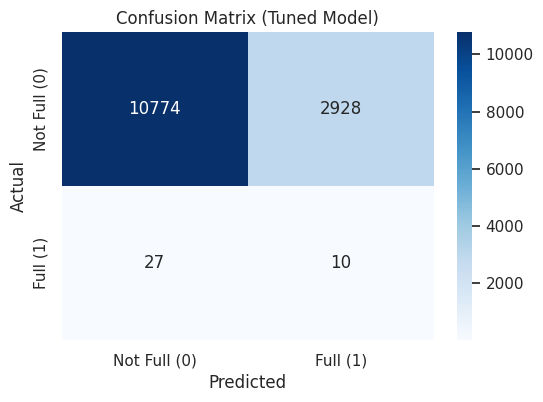


--- Classification Report (Tuned Model) ---
              precision    recall  f1-score   support

Not Full (0)       1.00      0.79      0.88     13702
    Full (1)       0.00      0.27      0.01        37

    accuracy                           0.78     13739
   macro avg       0.50      0.53      0.44     13739
weighted avg       0.99      0.78      0.88     13739



In [ ]:
if 'X_train_scaled' in locals():
    print("--- Task 2: Hyperparameter Tuning for XGBoost Classifier ---")
    print("(This may take some time, especially with the imbalanced data)...")

    # Use the previously initialized model with scale_pos_weight
    model_xgb_cls_tuned = xgb.XGBClassifier(objective='binary:logistic',
                                            eval_metric='logloss', # Use logloss during training
                                            scale_pos_weight=scale_pos_weight, # Keep imbalance handling
                                            random_state=42,
                                            n_jobs=-1)

    # Define a parameter grid for tuning.
    # Focus on parameters that can influence how the model handles complexity and fits the data.
    param_grid_xgb_cls = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.7, 1.0], # Ratio of the training instances.
        'colsample_bytree': [0.7, 1.0] # Subsample ratio of columns when constructing each tree.
    }

    # Use TimeSeriesSplit for cross-validation
    tscv_grid = TimeSeriesSplit(n_splits=5)

    # Use roc_auc as the scoring metric for GridSearchCV, as it's suitable for imbalanced data
    grid_search_cls = GridSearchCV(estimator=model_xgb_cls_tuned,
                                   param_grid=param_grid_xgb_cls,
                                   cv=tscv_grid,
                                   scoring='roc_auc', # Optimize for ROC-AUC
                                   n_jobs=-1,
                                   verbose=1)

    # Fit the grid search on the training data
    grid_search_cls.fit(X_train_scaled, y_cls_train)

    print(f"\nBest parameters found: {grid_search_cls.best_params_}")
    print(f"Best cross-validation ROC-AUC: {grid_search_cls.best_score_:.3f}")

    # Evaluate the Tuned Model
    best_xgb_cls = grid_search_cls.best_estimator_
    print("\n--- Evaluating Tuned XGBoost Classifier on Test Set ---")
    y_pred_cls_tuned = best_xgb_cls.predict(X_test_scaled)
    y_proba_cls_tuned = best_xgb_cls.predict_proba(X_test_scaled)[:, 1]

    print(f"Accuracy: {accuracy_score(y_cls_test, y_pred_cls_tuned):.3f}")
    print(f"ROC-AUC Score: {roc_auc_score(y_cls_test, y_proba_cls_tuned):.3f}")

    print("\n--- Confusion Matrix (Tuned Model) ---")
    cm_tuned = confusion_matrix(y_cls_test, y_pred_cls_tuned)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Full (0)', 'Full (1)'],
                yticklabels=['Not Full (0)', 'Full (1)'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix (Tuned Model)')
    plt.show()

    print("\n--- Classification Report (Tuned Model) ---")
    print(classification_report(y_cls_test, y_pred_cls_tuned, target_names=['Not Full (0)', 'Full (1)']))

else:
    print("Training data not found. Please run the preprocessing cell.")

# **Task 2: Classification - Predicting Near-Capactiy (>90% Full)**

--- Task 2: CLASSIFICATION Model Training (XGBoost) ---

Base XGBoost Classifier model trained.

--- Evaluating Base XGBoost Classifier on Test Set ---
Accuracy: 0.979
ROC-AUC Score: 0.724

--- Confusion Matrix ---


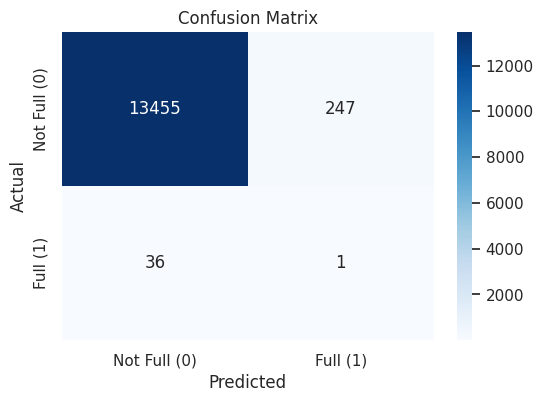


--- Classification Report ---
              precision    recall  f1-score   support

Not Full (0)       1.00      0.98      0.99     13702
    Full (1)       0.00      0.03      0.01        37

    accuracy                           0.98     13739
   macro avg       0.50      0.50      0.50     13739
weighted avg       0.99      0.98      0.99     13739



In [ ]:
if 'X_train_scaled' in locals():
    print("--- Task 2: CLASSIFICATION Model Training (XGBoost) ---")

    # 1. Handle Class Imbalance (Check)
    # 'Is_Full' is likely imbalanced (few '1's, many '0's)
    # We can use 'scale_pos_weight' to handle this.
    # This calculation has been moved to the preprocessing cell (Qk2jd6gS0Xag)
    # scale_pos_weight = (y_cls_train == 0).sum() / (y_cls_train == 1).sum()
    # print(f"Class balance check: 'Is_Full' = 1 occurs {100/scale_pos_weight:.2f}% of the time in the training set.")
    # print(f"Using 'scale_pos_weight' of: {scale_pos_weight:.2f}")

    # 2. Initialize the XGBoost Classifier
    model_xgb_cls = xgb.XGBClassifier(objective='binary:logistic',
                                        eval_metric='logloss',
                                        scale_pos_weight=scale_pos_weight, # Handle imbalance
                                        n_estimators=100,
                                        random_state=42,
                                        n_jobs=-1)

    # 3. Train the model
    model_xgb_cls.fit(X_train_scaled, y_cls_train)
    print("\nBase XGBoost Classifier model trained.")

    # 4. Evaluate the base model on the test set
    print("\n--- Evaluating Base XGBoost Classifier on Test Set ---")
    y_pred_cls = model_xgb_cls.predict(X_test_scaled)
    y_proba_cls = model_xgb_cls.predict_proba(X_test_scaled)[:, 1] # Get probabilities for class 1

    print(f"Accuracy: {accuracy_score(y_cls_test, y_pred_cls):.3f}")
    print(f"ROC-AUC Score: {roc_auc_score(y_cls_test, y_proba_cls):.3f}")

    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_cls_test, y_pred_cls)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Full (0)', 'Full (1)'],
                yticklabels=['Not Full (0)', 'Full (1)'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    print("\n--- Classification Report ---")
    print(classification_report(y_cls_test, y_pred_cls, target_names=['Not Full (0)', 'Full (1)']))

else:
    print("Training data not found. Please run the preprocessing cell.")

# **Model Feature Importance**

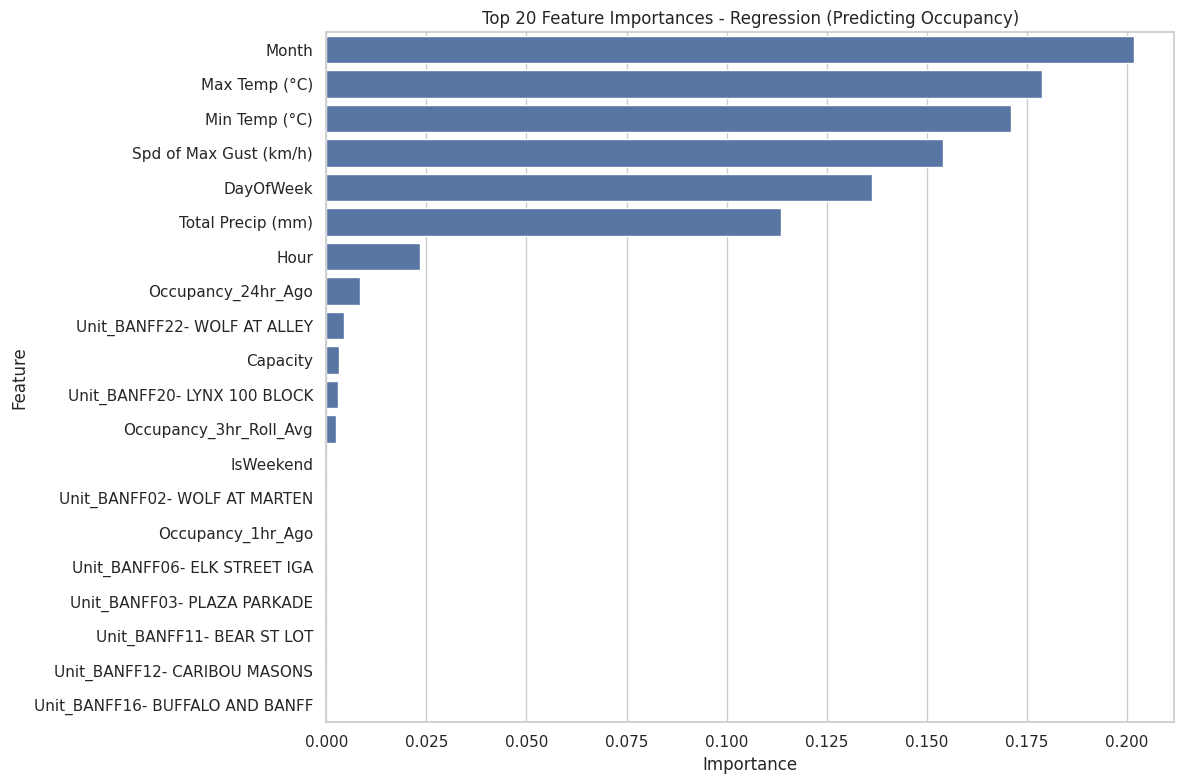

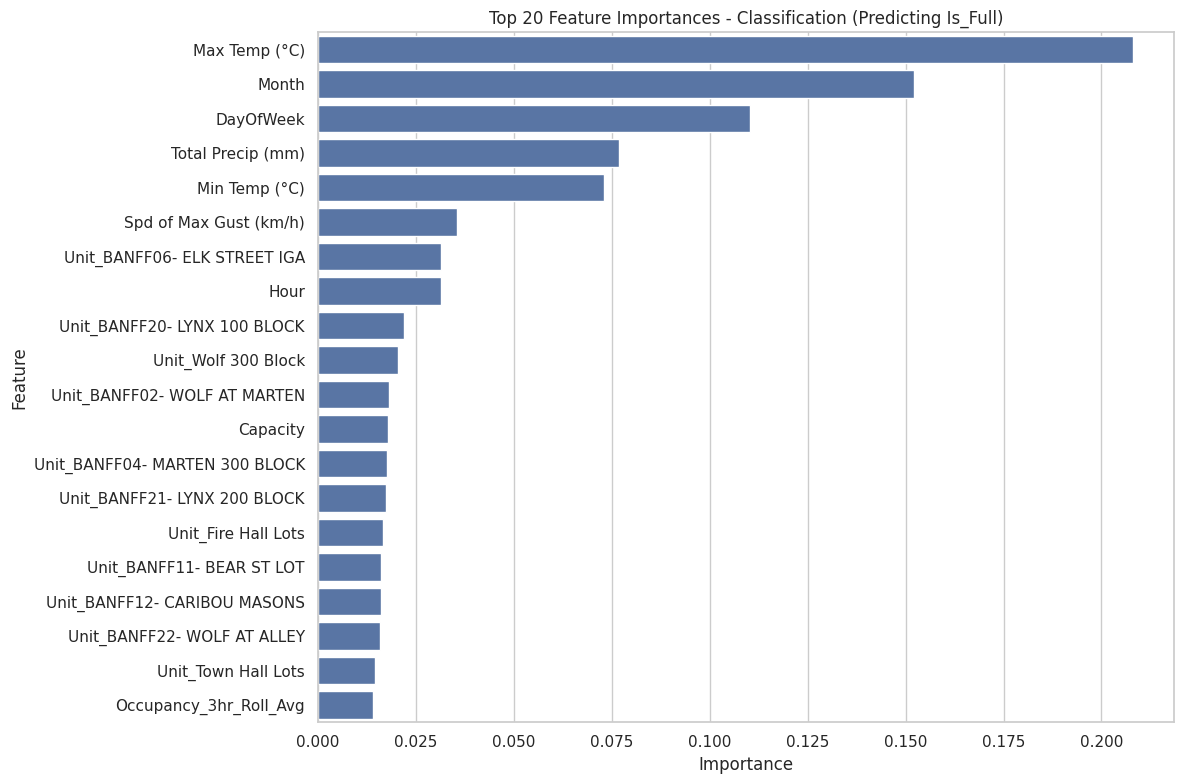

In [ ]:
def plot_feature_importance(model, feature_names, title):
    """Helper function to plot feature importance."""
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    # Get top 20 features
    top_20 = importance_df.head(20)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=top_20)
    plt.title(f'Top 20 Feature Importances - {title}')
    plt.tight_layout()
    plt.show()

if 'best_xgb_reg' in locals() and 'model_xgb_cls' in locals():
    # Plot for Regression Model
    plot_feature_importance(best_xgb_reg, FEATURES, 'Regression (Predicting Occupancy)')

    # Plot for Classification Model
    plot_feature_importance(model_xgb_cls, FEATURES, 'Classification (Predicting Is_Full)')
else:
    print("Models not trained yet. Please run the model training cells.")

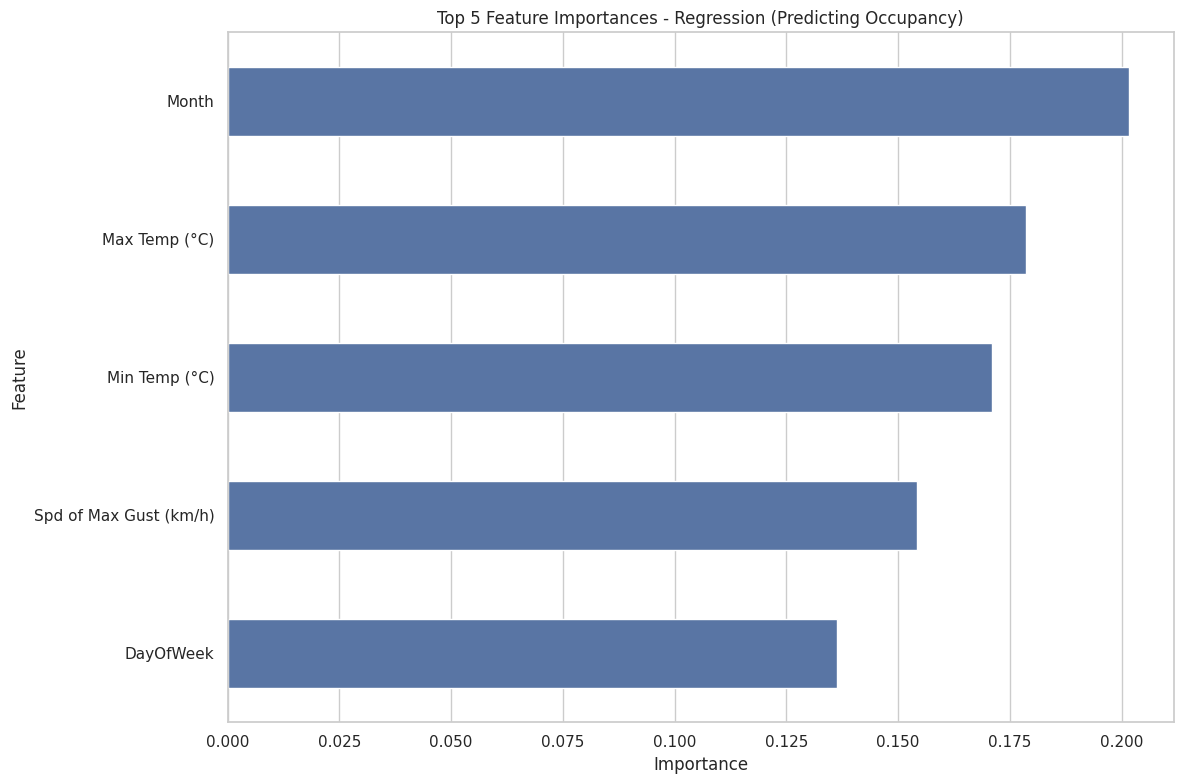

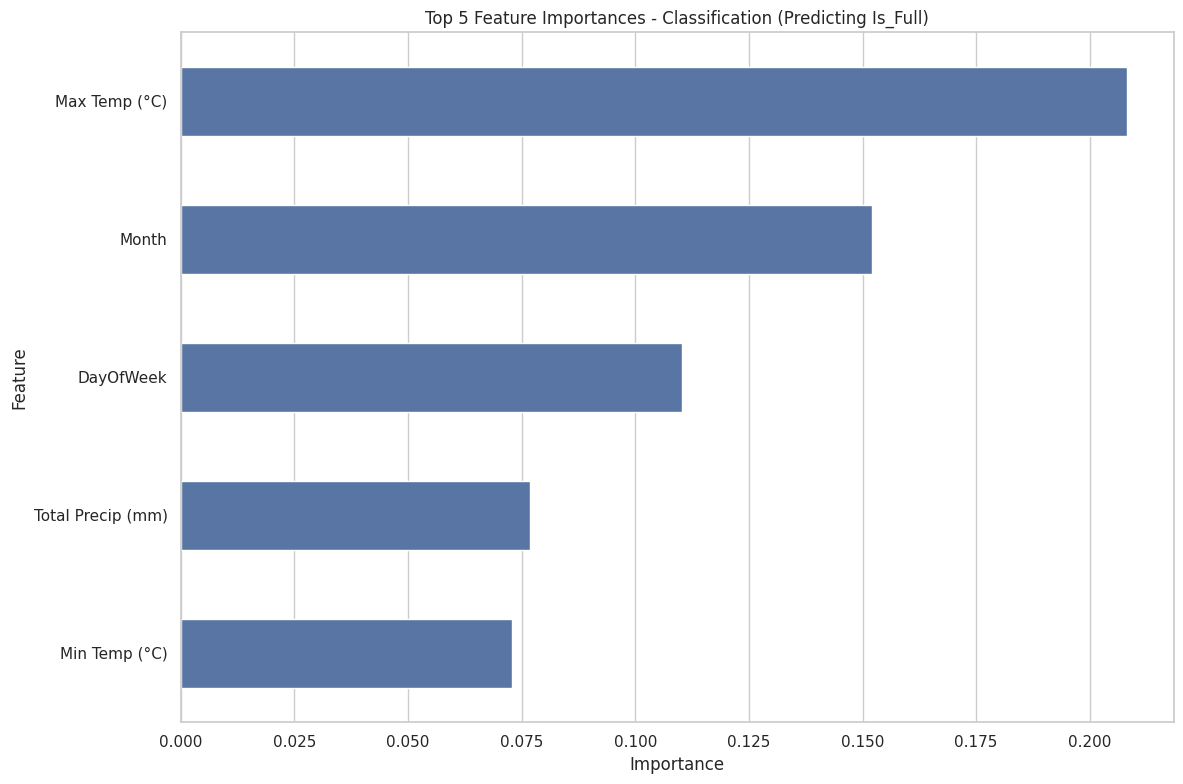

In [ ]:
def plot_feature_importance(model, feature_names, title):
    """Helper function to plot feature importance."""
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    # Get top 5 features
    top_5 = importance_df.head(5)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=top_5, width=0.5)
    plt.title(f'Top 5 Feature Importances - {title}')
    plt.tight_layout()
    plt.show()

if 'best_xgb_reg' in locals() and 'model_xgb_cls' in locals():
    # Plot for Regression Model
    plot_feature_importance(best_xgb_reg, FEATURES, 'Regression (Predicting Occupancy)')

    # Plot for Classification Model
    plot_feature_importance(model_xgb_cls, FEATURES, 'Classification (Predicting Is_Full)')
else:
    print("Models not trained yet. Please run the model training cells.")